## Mengimpor Pustaka dan Mengatur Direktori

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pickle
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
base_path = '/content/drive/My Drive/TA_OmarDhani/'

with open(base_path + 'X_train.pickle', 'rb') as f:
    X_train = pickle.load(f)

with open(base_path + 'X_val.pickle', 'rb') as f:
    X_val = pickle.load(f)

with open(base_path + 'X_test.pickle', 'rb') as f:
    X_test = pickle.load(f)

with open(base_path + 'y_train.pickle', 'rb') as f:
    y_train = pickle.load(f)

with open(base_path + 'y_val.pickle', 'rb') as f:
    y_val = pickle.load(f)

with open(base_path + 'y_test.pickle', 'rb') as f:
    y_test = pickle.load(f)


In [4]:
# Convert grayscale images to RGB by repeating the single channel three times
X_train_rgb = np.repeat(X_train, 3, axis=-1)
X_val_rgb = np.repeat(X_val, 3, axis=-1)
X_test_rgb = np.repeat(X_test, 3, axis=-1)


In [5]:
# Ensure data is in numpy array format
X_train_rgb = np.array(X_train_rgb)
X_val_rgb = np.array(X_val_rgb)
X_test_rgb = np.array(X_test_rgb)
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

In [6]:
# One-hot encode the labels
num_classes = 2
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [7]:
input_shape = (128, 128, 3)  # Adjusted for RGB images

weight_decay = 0.0001
learning_rate = 0.001
label_smoothing = 0.1
batch_size = 128
num_epochs = 100
patch_size = 4  # Size of the patches to be extracted from the input images.
embedding_dim = 64  # Number of hidden units.
mlp_dim = 64
num_heads = 4
attention_dropout = 0.1
projection_dropout = 0.1
num_transformer_blocks = 8

In [8]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.2),
        layers.RandomContrast(factor=0.2),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ],
    name="data_augmentation",
)

data_augmentation.layers[0].adapt(X_train_rgb)

In [9]:
class PatchExtract(layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size

    def call(self, x):
        batch_size, height, width, channels = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2], tf.shape(x)[3]
        patches = tf.image.extract_patches(
            images=x,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patches = tf.reshape(patches, [batch_size, -1, self.patch_size * self.patch_size * channels])
        return patches

class PatchEmbedding(layers.Layer):
    def __init__(self, num_patch, embed_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patch = num_patch
        self.proj = layers.Dense(embed_dim)
        self.pos_embed = layers.Embedding(input_dim=num_patch, output_dim=embed_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patch, delta=1)
        return self.proj(patch) + self.pos_embed(positions)

In [10]:
class ExternalAttention(layers.Layer):
    def __init__(self, dim, num_heads, dim_coefficient=4, attention_dropout=0, projection_dropout=0, **kwargs):
        super().__init__(**kwargs)
        self.dim = dim
        self.num_heads = num_heads * dim_coefficient
        self.dim_coefficient = dim_coefficient
        self.attention_dropout = attention_dropout
        self.projection_dropout = projection_dropout

        self.dense1 = layers.Dense(self.dim * self.dim_coefficient)
        self.dense2 = layers.Dense(self.dim // self.dim_coefficient)
        self.dense3 = layers.Dense(self.dim * self.dim_coefficient // self.num_heads)
        self.dense4 = layers.Dense(self.dim)
        self.softmax = layers.Softmax(axis=2)
        self.dropout1 = layers.Dropout(self.attention_dropout)
        self.dropout2 = layers.Dropout(self.projection_dropout)

    def call(self, x):
        batch_size, num_patch, channels = tf.shape(x)[0], tf.shape(x)[1], tf.shape(x)[2]
        x = self.dense1(x)
        x = tf.reshape(x, [batch_size, num_patch, self.num_heads, self.dim * self.dim_coefficient // self.num_heads])
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        attn = self.dense2(x)
        attn = self.softmax(attn)
        attn = tf.keras.layers.Lambda(lambda attn: attn / (1e-9 + tf.reduce_sum(attn, axis=-1, keepdims=True)))(attn)
        attn = self.dropout1(attn)
        x = self.dense3(attn)
        x = tf.transpose(x, perm=[0, 2, 1, 3])
        x = tf.reshape(x, [batch_size, num_patch, self.dim * self.dim_coefficient])
        x = self.dense4(x)
        x = self.dropout2(x)
        return x

In [11]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [12]:
def transformer_encoder(x, embed_dim, num_heads, mlp_dim, dropout, attention_type="self_attention"):
    # Normalization and Attention Mechanism
    x1 = layers.LayerNormalization(epsilon=1e-6)(x)
    if attention_type == "external_attention":
        attention_output = ExternalAttention(
            dim=embed_dim, num_heads=num_heads, attention_dropout=dropout, projection_dropout=dropout
        )(x1)
    else:
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim, dropout=dropout
        )(x1, x1)

    # Skip connection
    x2 = layers.Add()([attention_output, x])

    # Normalization and MLP
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    x3 = mlp(x3, hidden_units=[mlp_dim, embed_dim], dropout_rate=dropout)

    # Skip connection
    return layers.Add()([x3, x2])

## Implementasi GSA untuk Mengoptimalkan Parameter EAT

In [13]:
def create_eat_classifier():
    inputs = keras.Input(shape=input_shape)
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = PatchExtract(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEmbedding((input_shape[0] // patch_size) ** 2, embedding_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(num_transformer_blocks):
        encoded_patches = transformer_encoder(
            encoded_patches, embedding_dim, num_heads, mlp_dim, attention_dropout, attention_type="external_attention"
        )

    # Create a [batch_size, projection_dim] tensor.
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.3)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=[2048, 1024], dropout_rate=0.3)
    # Classify outputs.
    logits = layers.Dense(num_classes)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=logits)
    return model


In [14]:
def run_experiment(model):
    optimizer = keras.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )

    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True, label_smoothing=label_smoothing),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
        ],
    )

    checkpoint_filepath = "/content/drive/My Drive/TA_OmarDhani/checkpoint_Scheme_3.weights.h5"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(
        X_train_rgb,
        y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_data=(X_val_rgb, y_val),
        callbacks=[checkpoint_callback],
    )

    model.load_weights(checkpoint_filepath)
    _, accuracy = model.evaluate(X_test_rgb, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

    return history

# Function to save history
def save_history(history, history_directory, history_filename):
    history_path = os.path.join(history_directory, history_filename)
    with open(history_path, 'wb') as f:
        pickle.dump(history.history, f)

# Function to load history
def load_history(history_directory, history_filename):
    history_path = os.path.join(history_directory, history_filename)
    with open(history_path, 'rb') as f:
        return pickle.load(f)

eat_classifier = create_eat_classifier()
history = run_experiment(eat_classifier)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 38s 930ms/step - accuracy: 0.4861 - loss: 56.4835 - val_accuracy: 0.5605 - val_loss: 2.7032
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 766ms/step - accuracy: 0.5171 - loss: 4.8175 - val_accuracy: 0.6123 - val_loss: 1.2466
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.5612 - loss: 1.9673 - val_accuracy: 0.5950 - val_loss: 0.7668
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 7s 761ms/step - accuracy: 0.5770 - loss: 1.0585 - val_accuracy: 0.6718 - val_loss: 0.6568
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 223ms/step - accuracy: 0.6019 - loss: 0.7960 - val_accuracy: 0.6699 - val_loss: 0.6260
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 222ms/step - accuracy: 0.6147 - loss: 0.7179 - val_accuracy: 0.6104 - val_loss: 0.6387
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.6173 - loss: 0.6690 - val_accuracy: 0.6392 - val_loss: 0.6351
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 227ms/step - accuracy: 0.6472 - loss: 0.6605 - val_ac

In [15]:
# Save the history
history_directory = "/content/drive/My Drive/TA_OmarDhani/"
history_filename = "history_Scheme3.pkl"
save_history(history, history_directory, history_filename)

In [16]:
def plot_history(history):
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.plot(history['accuracy'], label='Train Accuracy')
    plt.plot(history['val_accuracy'], label='Validation Accuracy')
    plt.title('Train and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title('Train and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()

    plt.show()

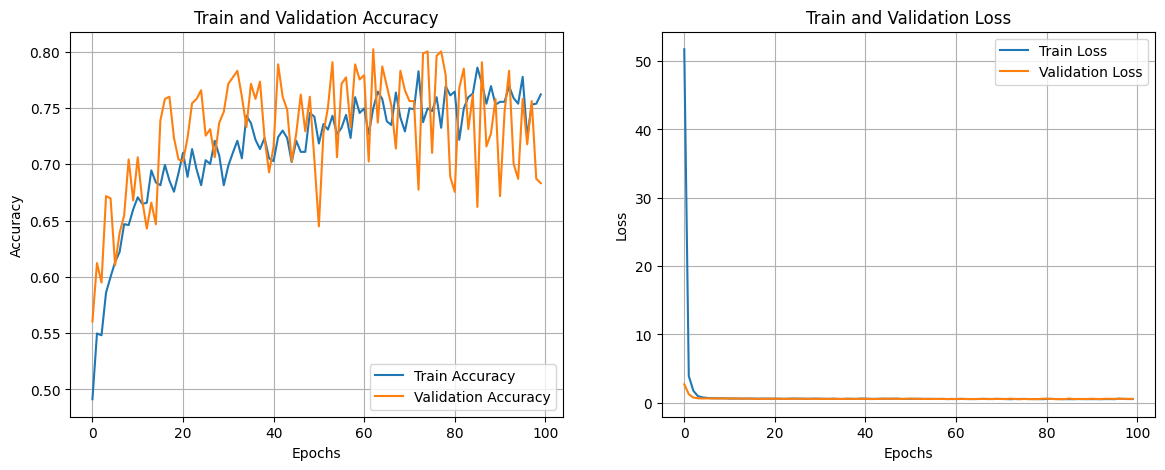

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step

Classification Report:

              precision    recall  f1-score   support

           0       0.74      0.84      0.79       369
           1       0.82      0.72      0.77       376

    accuracy                           0.78       745
   macro avg       0.78      0.78      0.78       745
weighted avg       0.78      0.78      0.78       745



In [17]:
# Load the history and plot
loaded_history = load_history(history_directory, history_filename)
plot_history(loaded_history)

# Get predictions
y_pred = eat_classifier.predict(X_test_rgb)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Generate classification report
print("\nClassification Report:\n")
print(classification_report(y_true_classes, y_pred_classes))

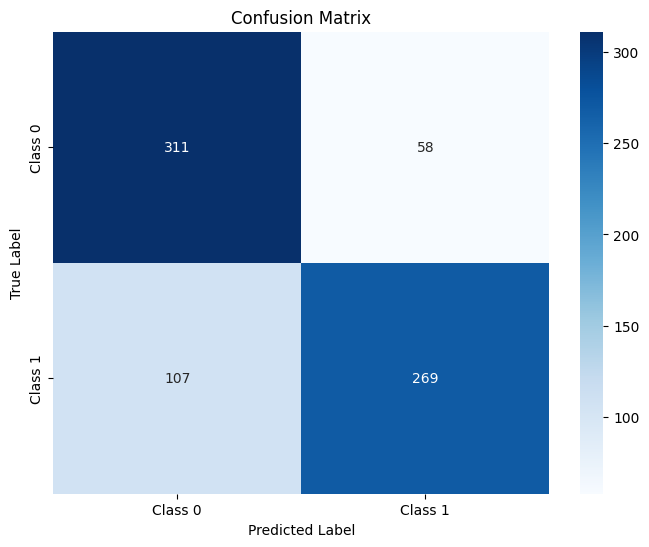

In [18]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()